In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


List all my dataset:

In [ ]:
! ls /content/drive/MyDrive/silo_agg/csv

2014_max_temp_daily_mean.csv  2022_min_temp_daily_mean.csv
2014_min_temp_daily_mean.csv  2022_rain_daily_mean.csv
2014_rain_daily_mean.csv      2022_vp_daily_mean.csv
2014_vp_daily_mean.csv	      2023_max_temp_daily_mean.csv
2015_max_temp_daily_mean.csv  2023_min_temp_daily_mean.csv
2015_min_temp_daily_mean.csv  2023_rain_daily_mean.csv
2015_rain_daily_mean.csv      2023_vp_daily_mean.csv
2015_vp_daily_mean.csv	      2024_max_temp_daily_mean.csv
2016_max_temp_daily_mean.csv  2024_min_temp_daily_mean.csv
2016_min_temp_daily_mean.csv  2024_rain_daily_mean.csv
2016_rain_daily_mean.csv      2024_vp_daily_mean.csv
2016_vp_daily_mean.csv	      ERA5L_SA_2014.csv
2017_max_temp_daily_mean.csv  ERA5L_SA_2015.csv
2017_min_temp_daily_mean.csv  ERA5L_SA_2016.csv
2017_rain_daily_mean.csv      ERA5L_SA_2017.csv
2017_vp_daily_mean.csv	      ERA5L_SA_2018.csv
2018_max_temp_daily_mean.csv  ERA5L_SA_2019.csv
2018_min_temp_daily_mean.csv  ERA5L_SA_2020.csv
2018_rain_daily_mean.csv      ERA5L_SA_2021.csv
2

List my output figures:

In [ ]:
! ls /content/drive/MyDrive/silo_agg/output/figures

box_t_by_cluster.png	     hist_hotspots.png	  scatter_t_hotspots.png
choropleth_hotspots.png      hotspots_map.html	  silhouette.png
corr_heatmap.png	     pca_clusters.png	  tsne_clusters.png
facet_scatter_by_region.png  scatter_layered.png


In [ ]:
import pandas as pd, numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd, re
from itertools import islice

This code inspects the structure of multiple CSV files, previews sample rows from each type, and defines a robust function to load and standardize bushfire hotspot data for analysis.


In [ ]:
CSV = Path("/content/drive/MyDrive/silo_agg/csv")

# 1.Inspect every CSV header
print("Scanning headers …\n")
for f in sorted(CSV.glob("*.csv")):
    # read only the header row
    cols = pd.read_csv(f, nrows=0).columns.tolist()
    # show first 6 cols only
    print(f.name.ljust(28), ":", cols[:6], "…")

# 2. Peek at sample rows from one file of each family
def sample_rows(pattern):
    file = next(iter(sorted(CSV.glob(pattern))), None)
    if not file:
        print(f"\n No file matched {pattern}")
        return
    print(f"\n Sample rows from {file.name}")
    display(pd.read_csv(file, nrows=2))

sample_rows("hotspots_AU_2014.csv")
sample_rows("2014_max_temp_daily_mean.csv")
sample_rows("ERA5L_SA_2014.csv")

# 3.Robust loader util for hotspot CSVs
def load_hotspots(year):
    """Return DF with columns: date, lat, lon, confidence"""
    f = CSV / f"hotspots_AU_{year}.csv"
    # discover the TRUE date-column name
    hdr = pd.read_csv(f, nrows=0).columns.str.lower()
    date_col = next((c for c in hdr if re.match(r"(acq_)?date", c)), None)
    if date_col is None:
        raise ValueError(f"No date column found in {f.name}")
    rename_map = {date_col: "date"}
    # latitude /longitude sometimes written as 'lat'/'lon'
    for c in ["latitude", "lat"]:
        if c in hdr:
            rename_map[c] = "lat"
            break
    for c in ["longitude", "lon"]:
        if c in hdr:
            rename_map[c] = "lon"
            break
    df = pd.read_csv(f, parse_dates=[date_col])
    df = df.rename(columns=rename_map)
    df["date"] = df["date"].dt.normalize()
    # choose whichever confidence column exists
    #fallback if none provided
    conf_col = next((c for c in ["confidence", "confidence_level"] if c in df.columns), None)
    if conf_col:
        df = df.rename(columns={conf_col: "confidence"})
    else:
        df["confidence"] = 100
    return df[["date", "lat", "lon", "confidence"]]

print("\n `load_hotspots()` ready – try `load_hotspots(2014).head()`")


Scanning headers …

2014_max_temp_daily_mean.csv → ['time', 'max_temp_C'] …
2014_min_temp_daily_mean.csv → ['time', 'min_temp_C'] …
2014_rain_daily_mean.csv     → ['time', 'rain_mm'] …
2014_vp_daily_mean.csv       → ['time', 'vp_kPa'] …
2015_max_temp_daily_mean.csv → ['time', 'max_temp_C'] …
2015_min_temp_daily_mean.csv → ['time', 'min_temp_C'] …
2015_rain_daily_mean.csv     → ['time', 'rain_mm'] …
2015_vp_daily_mean.csv       → ['time', 'vp_kPa'] …
2016_max_temp_daily_mean.csv → ['time', 'max_temp_C'] …
2016_min_temp_daily_mean.csv → ['time', 'min_temp_C'] …
2016_rain_daily_mean.csv     → ['time', 'rain_mm'] …
2016_vp_daily_mean.csv       → ['time', 'vp_kPa'] …
2017_max_temp_daily_mean.csv → ['time', 'max_temp_C'] …
2017_min_temp_daily_mean.csv → ['time', 'min_temp_C'] …
2017_rain_daily_mean.csv     → ['time', 'rain_mm'] …
2017_vp_daily_mean.csv       → ['time', 'vp_kPa'] …
2018_max_temp_daily_mean.csv → ['time', 'max_temp_C'] …
2018_min_temp_daily_mean.csv → ['time', 'min_temp_C'] …


,FID,id,satellite,satellite_nssdc_id,satellite_operating_agency,sensor,orbit,start_dt,stop_dt,filename,...,load_dt,latitude,longitude,location,temp_kelvin,power,confidence,datetime,australian_state,accuracy
0,hotspots.fid-58e6507a_1976db59321_-1113,8890856,TERRA,1999-068A,NASA,MODIS,74671,2013-12-31T23:55:49,2014-01-01T00:05:04,Terra20131231T235549Z20140101T000504Zhotspots.txt,...,NaN,-33.0816,150.5591,POINT (-33.081615 150.559113),327.5,19.1,70,2014-01-01T00:00:00,NSW,± 1km
1,hotspots.fid-58e6507a_1976db59321_-1112,8890980,TERRA,1999-068A,NASA,MODIS,74671,2013-12-31T23:55:49,2014-01-01T00:05:04,Terra20131231T235549Z20140101T000504Zhotspots.txt,...,NaN,-24.5857,149.1068,POINT (-24.585651 149.106812),325.3,16.5,76,2014-01-01T00:00:00,QLD,± 1km



📄 Sample rows from 2014_max_temp_daily_mean.csv


,time,max_temp_C
0,2014-01-01,37.432282
1,2014-01-02,37.372775



📄 Sample rows from ERA5L_SA_2014.csv


,valid_time,latitude,longitude,t2m,d2m,u10,v10,tp,ssrd,number,expver
0,2014-01-01,-25.0,129.0,306.28955,287.6167,4.203278,-3.199158,0.000002,24942912.0,0,1
1,2014-01-01,-25.0,129.1,306.31494,287.5249,4.209137,-3.104431,0.000002,24909092.0,0,1



 `load_hotspots()` ready – try `load_hotspots(2014).head()`


I set the project root folder, CSV directory, and file paths to the NRM region shapefiles, defined the years for the analysis (2014-2024), and ensured that output folders for graphics and cached data were created.

In [ ]:
# EDIT THESE 3 PATHS
# EPSG:4326 shapefile/gpkg
ROOT      = Path("/content/drive/MyDrive/silo_agg")
# Show where all CSVs live
CSV_DIR   = ROOT / "csv"
NRM_SHAPE = ROOT / "nrm_superclusters/ADMIN_NrmRegions_GDA2020.shp"
# # 2014-2024
YEARS = range(2014, 2025)

OUT    = ROOT / "output";  FIG = OUT / "figures";  CACHE = OUT / "parquet"
for p in (FIG, CACHE): p.mkdir(parents=True, exist_ok=True)

Five rows from the weather CSV file are previewed, and wind speed and vapor pressure difference (VPD) are calculated as new columns and displayed along with the main original features.

In [ ]:
# Preview new features from ERA5L_SA_2014.csv
sample = pd.read_csv(CSV_DIR / "ERA5L_SA_2014.csv", nrows=5)

# Wind speed (already have u10 &v10)
sample["ws_ms"] = np.hypot(sample.u10, sample.v10).round(2)

# VPD, optional but looks great in the table
svp  = 0.6108 * np.exp((17.27*(sample.t2m-273.15)) / (sample.t2m-35.85))
svp_d= 0.6108 * np.exp((17.27*(sample.d2m-273.15)) / (sample.d2m-35.85))
sample["vpd_kPa"] = (svp - svp_d).round(3)

print(sample[["valid_time","latitude","longitude","t2m","d2m","ws_ms","vpd_kPa"]])


   valid_time  latitude  longitude        t2m        d2m  ws_ms  vpd_kPa
0  2014-01-01     -25.0      129.0  306.28955  287.61670   5.28    3.422
1  2014-01-01     -25.0      129.1  306.31494  287.52490   5.23    3.439
2  2014-01-01     -25.0      129.2  306.42040  287.52295   5.17    3.469
3  2014-01-01     -25.0      129.3  306.54932  287.54248   5.12    3.504
4  2014-01-01     -25.0      129.4  306.74463  287.62842   5.09    3.551


In [ ]:
import os, humanize, pandas as pd
era_file = CSV_DIR / "ERA5L_SA_2014.csv"
hot_file = CSV_DIR / "hotspots_AU_2014.csv"

era_rows = pd.read_csv(era_file, usecols=[0]).shape[0]
hot_rows = pd.read_csv(hot_file, usecols=[0]).shape[0]

print("ERA5-Land 2014:", era_rows, "rows ", humanize.naturalsize(os.path.getsize(era_file)))
print("Hotspots 2014:", hot_rows, "rows ", humanize.naturalsize(os.path.getsize(hot_file)))


ERA5-Land 2014 → 138854760 rows | 14.8 GB
Hotspots 2014 → 300000 rows | 78.9 MB


I summed the total number of rows for all yearly hotspots and ERA5-Land CSVs, checked the sizes of intermediate aggregates and the final merged dataset, and printed out the number of rows for each key stage of data processing.

In [ ]:
import pandas as pd
import pathlib

# Paths to cached files
CSV_DIR = pathlib.Path("/content/drive/MyDrive/silo_agg/csv")
OUT_DIR = pathlib.Path("/content/drive/MyDrive/silo_agg/output")

# 1. Raw file row counts (totalled across all years)
# Sum rows over every yearly CSV for each dataset family
hotspot_rows = sum(
    pd.read_csv(p, usecols=[0]).shape[0]
    for p in CSV_DIR.glob("hotspots_AU_*.csv")
)
era5_rows    = sum(
    pd.read_csv(p, usecols=[0]).shape[0]
    for p in CSV_DIR.glob("ERA5L_SA_*.csv")
)

# 2. Intermediate aggregation counts
try:
    ignitions = pd.read_parquet(OUT_DIR/"ignitions.parquet")
    wx_nrm    = pd.read_parquet(OUT_DIR/"wx_nrm.parquet")
    nrm_ignitions = len(ignitions)
    era5_nrm       = len(wx_nrm)
except FileNotFoundError:
    print("ignitions.parquet or wx_nrm.parquet not found; skipping those counts.")
    nrm_ignitions = None
    era5_nrm       = None

# 3. Final panel count
panel = pd.read_parquet(OUT_DIR/"sa_daily_panel.parquet")
merged_panel = len(panel)

# 4. Print the counts
print(f"Total raw hotspots 2014–24: {hotspot_rows:,} rows")
print(f"Total raw ERA5-Land 2014–24: {era5_rows:,} rows")

if nrm_ignitions is not None:
    print(f"NRM–day ignition records: {nrm_ignitions:,} rows")

if era5_nrm is not None:
    print(f"ERA5： NRM aggregation: {era5_nrm:,} rows")

print(f"Final merged panel: {merged_panel:,} rows")


ignitions.parquet or wx_nrm.parquet not found; skipping those counts.
Total raw hotspots 2014–24  → 3,300,000 rows
Total raw ERA5-Land 2014–24 → 1,528,543,632 rows
Final merged panel         → 19,516 rows


I want to define a function that robustly loads hotspot data for any year, standardizes column names and types, handles missing values, and merges data from all years into a DataFrame, filtering out low-confidence records.

In [ ]:
def load_hotspots(year: int) -> pd.DataFrame:
    f = CSV_DIR / f"hotspots_AU_{year}.csv"
    cols = pd.read_csv(f, nrows=0).columns
    cols_lc = cols.str.lower()

    # 1.PICK THE RIGHT DATE COLUMN (priority order)
    preferred = ["datetime", "date", "acq_date"]
    date_col = next((c for p in preferred for c in cols if c.lower() == p), None)
    if date_col is None:
        date_col = next((c for c in cols if c.lower().endswith("_dt")), None)
    if date_col is None:
        raise ValueError(f"No datetime column found in {f.name}")

    # 2. OTHER COLUMNS
    lat_col  = next(c for c in cols if c.lower() in ("latitude", "lat"))
    lon_col  = next(c for c in cols if c.lower() in ("longitude", "lon"))
    conf_col = next((c for c in cols if "confidence" in c.lower()), None)

    use_cols = [date_col, lat_col, lon_col] + ([conf_col] if conf_col else [])
    df = pd.read_csv(f, usecols=use_cols)

    # 3. RENAME and CONVERT
    rename_map = {date_col: "date", lat_col: "lat", lon_col: "lon"}
    if conf_col:
        rename_map[conf_col] = "confidence"
    df = df.rename(columns=rename_map)

    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()
    # How I drop any bad rows
    df = df.dropna(subset=["date"])

    if "confidence" not in df:
        df["confidence"] = 100.0

    return df[["date", "lat", "lon", "confidence"]]

hotspots = pd.concat([load_hotspots(y) for y in YEARS])
hotspots = hotspots.query("confidence >= 30").copy()

I would like to see the percentage of missing values, rounded to two decimal places and displayed with a percent sign.

In [ ]:
print(panel.isna().mean().mul(100).round(2).astype(str) + "%")

date                0.0%
nrm_id              0.0%
t2m_K              0.45%
wind_ms            0.45%
rh_pct             0.45%
hotspot_cnt         0.0%
target_next_day     0.0%
t2m_C              0.45%
cluster            0.45%
tsne_x             0.45%
tsne_y             0.45%
dtype: object


In [ ]:
ROOT = Path("/content/drive/MyDrive/silo_agg")
SHP  = ROOT / "nrm_superclusters/ADMIN_NrmRegions_GDA2020.shp"
AUX  = ROOT / "aux"
AUX.mkdir(exist_ok=True)

CSV_OUT = AUX / "SA_NRM_lookup.csv"
PQ_OUT  = CSV_OUT.with_suffix(".parquet")

Here I read the region shape file, calculate the area and centroid of each region, and save a lookup table of these attributes in CSV and Parquet formats.

In [ ]:
# 1. Read shapefile, re-project to WGS84 for storage
nrm = gpd.read_file(SHP).to_crs(4326) # EPSG:4326
nrm = nrm.rename(columns={"REGION_ID": "nrm_id", "NAME": "nrm_name"})
nrm["nrm_id"] = nrm["nrm_id"].astype(int)

# 2. Area (km2) and centroid
# Use an equal-area CRS for accuracy (EPSG = GDA 94 /Australian Albers)
area_proj = nrm.to_crs(3577)
nrm["area_km2"] = (area_proj.area / 1e6).round(1)

centroids = area_proj.centroid.to_crs(4326)
nrm["lon_c"] = centroids.x.round(4)
nrm["lat_c"] = centroids.y.round(4)

# 3. Save lookup tables
cols = ["nrm_id", "nrm_name", "area_km2", "lon_c", "lat_c"]
nrm[cols].to_csv(CSV_OUT, index=False)
nrm[cols].to_parquet(PQ_OUT, index=False)

print("Lookup created:", CSV_OUT.name, "and", PQ_OUT.name)
print(nrm[cols].head())

Lookup created: SA_NRM_lookup.csv and SA_NRM_lookup.parquet
   nrm_id                               nrm_name  area_km2     lon_c    lat_c
0       6            South Australian Arid Lands  521800.4  137.3620 -29.2381
1       2                    Alinytjara Wilurara  282700.1  131.3553 -28.9035
2       7  South Australian Murray-Darling Basin   56874.8  139.9572 -34.3363
3       5                       Northern & Yorke   49900.9  138.0271 -33.7208
4       3                         Eyre Peninsula   81760.5  135.2101 -33.3621


This line prints the top regions by the number of hotspot records, displaying the names and counts of the regions with the most detected events.

In [ ]:
# Should show non-zero counts for several regions
print(
    hotspots_g["nrm_name"]
    .value_counts()
    .head()
)

nrm_name
South Australian Arid Lands              7773
Eyre Peninsula                           7630
Alinytjara Wilurara                      4435
Northern & Yorke                         4218
South Australian Murray-Darling Basin    3023
Name: count, dtype: int64


In [ ]:
pd.read_csv(CSV_DIR / "ERA5L_SA_2014.csv", nrows=0).columns

Index(['valid_time', 'latitude', 'longitude', 't2m', 'd2m', 'u10', 'v10', 'tp',
       'ssrd', 'number', 'expver'],
      dtype='object')

I removed incomplete rows, standardized the key features, reduced their dimensionality using PCA, clustered the data into four groups using KMeans, and stored the cluster labels in the cleaned DataFrame.

In [ ]:
# Drop the 88 incomplete rows, then recompute cluster / t-SNE
panel_clean = panel.dropna(subset=["t2m_K", "wind_ms", "rh_pct"]).reset_index(drop=True)
print("After drop:", panel_clean.shape)

# Cluster/TSNE refreshed:
std = StandardScaler().fit_transform(panel_clean[["t2m_K", "wind_ms", "rh_pct"]])
pca2 = PCA(n_components=2).fit_transform(std)
km   = KMeans(n_clusters=4, n_init="auto", random_state=42).fit(pca2)
panel_clean["cluster"] = km.labels_


After drop: (19428, 11)


I defined a function to load, clean, and enrich ERA5 weather data for any year, standardizing columns, handling missing dates, and calculating wind speed and relative humidity, then concatenating all years into a single DataFrame.

In [ ]:
# 1.ERA5 loader
def load_era5(year: int) -> pd.DataFrame:
    f = CSV_DIR / f"ERA5L_SA_{year}.csv"
    cols = ["valid_time", "latitude", "longitude", "t2m", "d2m", "u10", "v10"]
    df = pd.read_csv(f, usecols=cols, parse_dates=["valid_time"])

    # Rename columns
    df = df.rename(columns={"valid_time": "date",
                            "latitude": "lat",
                            "longitude": "lon"})

    # Robust datetime handling
    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()
    # safeguard against NaT rows
    df = df.dropna(subset=["date"])

    # Derived features
    df["wind_ms"] = np.hypot(df.u10, df.v10)

    es = 6.112 * np.exp((17.67 * (df.d2m - 273.15)) / (df.d2m - 29.65))
    ew = 6.112 * np.exp((17.67 * (df.t2m - 273.15)) / (df.t2m - 29.65))
    df["rh"] = 100 * es / ew

    return df[["date", "lat", "lon", "t2m", "wind_ms", "rh"]]

era5 = pd.concat([load_era5(y) for y in YEARS], ignore_index=True)
print("ERA5 rows:", len(era5))


ERA5 rows: 27324540


In [ ]:
print(nrm.columns)


Index(['REGION_ID', 'NAME', 'OFFICE_ID', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry'],
      dtype='object')


I renamed the region column for consistency and printed a sample for verification, then spatially joined the ERA5 weather data to the regions, aggregated the daily weather statistics by region, and printed the resulting row counts.

In [ ]:
# Make column names match what the rest of the notebook expects
nrm = nrm.rename(columns={
    "REGION_ID": "nrm_id",
    "NAME": "nrm_name"
})

# sanity-check
print(nrm[["nrm_id", "nrm_name"]].head())

# Spatial join and daily weather aggregation
wx_nrm = (
    gpd.sjoin(
        era5_g,
        nrm[["nrm_id", "geometry"]],
        how="inner",
        predicate="within"
    )
    .groupby(["date", "nrm_id"], observed=True)
    .agg(t2m_K   =("t2m",      "mean"),
         wind_ms =("wind_ms",  "mean"),
         rh_pct  =("rh",       "mean"))
    .reset_index()
)
print("Weather rows:", len(wx_nrm))


   nrm_id                               nrm_name
0     6.0            South Australian Arid Lands
1     2.0                    Alinytjara Wilurara
2     7.0  South Australian Murray-Darling Basin
3     5.0                       Northern & Yorke
4     3.0                         Eyre Peninsula
Weather rows: 19516


I assign each hotspot to its region, calculate daily ignition events for each region, and create a flag indicating if a threshold for high ignition risk is exceeded the next day.

In [ ]:
# re-create ignition counts with nrm_id and nrm_name
hotspots_g = gpd.GeoDataFrame(
    hotspots,
    geometry=gpd.points_from_xy(hotspots.lon, hotspots.lat),
    crs=4326,
)

# attach BOTH id and name, then drop geometry
hotspots_g = gpd.sjoin(
    hotspots_g,
    nrm[["nrm_id", "nrm_name", "geometry"]],
    how="inner",
    predicate="within"
).drop(columns="index_right")

ignitions = (
    hotspots_g.groupby(["date", "nrm_id", "nrm_name"], observed=True)
              .size()
              .reset_index(name="hotspot_cnt")
)

# next-day risk flag (shift within each region)
ignitions["target_next_day"] = (
    ignitions.groupby("nrm_id")["hotspot_cnt"].shift(-1).fillna(0) >= 10
).astype(int)

print("Ignition rows:", len(ignitions))
print(ignitions.head())


Ignition rows: 1211
        date  nrm_id                     nrm_name  hotspot_cnt  \
0 2014-01-03     6.0  South Australian Arid Lands            2   
1 2014-01-07     1.0   Adelaide & Mt Lofty Ranges            2   
2 2014-01-08     8.0                   South East            2   
3 2014-01-11     8.0                   South East            2   
4 2014-01-14     2.0          Alinytjara Wilurara            8   

   target_next_day  
0                1  
1                0  
2                0  
3                1  
4                1  


I merge daily weather and ignition data by region and date and fill missing ignition values ​​with zeros, sort the result again, save it as a parquet file, and print the shape and filename of the final panel.

In [ ]:
panel = (
    wx_nrm.merge(
        ignitions[["date", "nrm_id", "hotspot_cnt", "target_next_day"]],
        on=["date", "nrm_id"], how="left"
    )
    .fillna({"hotspot_cnt": 0, "target_next_day": 0})
    .sort_values(["nrm_id", "date"])
)

# cache results
panel_path = OUTDIR / "sa_daily_panel.parquet"
panel.to_parquet(panel_path, index=False)

print("panel saved:", panel.shape, ":", panel_path.name)


panel saved: (19516, 7) → sa_daily_panel.parquet


I also merged the regional daily weather and ignition data and filled the missing ignition information with zeros, saved the final panel as Parquet and CSV files, and finally printed the results for verification.

In [ ]:
# 4. Build & cache the final panel
from pathlib import Path

ROOT   = Path("/content/drive/MyDrive/silo_agg")
OUTDIR = ROOT / "output"
OUTDIR.mkdir(exist_ok=True)

# a. tidy types
wx_nrm["nrm_id"] = wx_nrm["nrm_id"].astype(int)

# b.merge weather : ignition counts
panel = (
    wx_nrm.merge(
        ignitions[["date", "nrm_id", "hotspot_cnt", "target_next_day"]],
        on=["date", "nrm_id"], how="left"
    )
    .fillna({"hotspot_cnt": 0, "target_next_day": 0})
    .sort_values(["nrm_id", "date"])
)

# 3. cache results
panel_path_pq  = OUTDIR / "sa_daily_panel.parquet"
panel_path_csv = OUTDIR / "sa_daily_panel.csv"

panel.to_parquet(panel_path_pq, index=False)
panel.to_csv(panel_path_csv, index=False)

print("panel saved:", panel.shape, ":", panel_path_pq.name)
print(panel.head())


panel saved: (19516, 7) → sa_daily_panel.parquet
         date  nrm_id       t2m_K   wind_ms     rh_pct  hotspot_cnt  \
9  2014-01-03       1  291.021552  6.619956  65.581457          0.0   
15 2014-01-04       1  289.782428  5.629855  50.956166          0.0   
23 2014-01-05       1  291.271989  8.510249  51.713904          0.0   
40 2014-01-10       1  301.997590  2.107849  42.423605          0.0   
46 2014-01-11       1  296.392980  2.938075  46.898584          0.0   

    target_next_day  
9               0.0  
15              0.0  
23              0.0  
40              0.0  
46              0.0  


I also mentioned this paragraph in my report. I print summary statistics such as count, mean, standard deviation, minimum, maximum and quartiles for all numerical columns in the “panel” DataFrame and transpose them for easier reading.

In [ ]:
print(panel.describe().T)

                   count                           mean                  min  \
date               19516  2019-07-02 22:18:10.551342336  2014-01-01 00:00:00   
nrm_id           19516.0                       4.379945                  1.0   
t2m_K            19428.0                     291.109073           276.996772   
wind_ms          19428.0                       4.119008             0.282083   
rh_pct           19428.0                      55.656397             5.998652   
hotspot_cnt      19516.0                       1.005841                  0.0   
target_next_day  19516.0                       0.017114                  0.0   

                                 25%                  50%  \
date             2016-10-01 12:00:00  2019-07-03 00:00:00   
nrm_id                           2.0                  5.0   
t2m_K                     285.745648           290.181258   
wind_ms                     2.842492             3.976281   
rh_pct                     42.840202            56.231

I generated and saved several key visualizations such as histograms, correlation heatmaps, scatter plots, and PCA clustering, and summarized the characteristics of each weather cluster.

In [ ]:
# 5.Visualisations & pattern mining
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path

FIG = OUTDIR / "figures"; FIG.mkdir(exist_ok=True)

# 1. Histogram: hotspot counts (log-x)
sns.histplot(panel["hotspot_cnt"], bins=50, log_scale=(True, False))
plt.xlabel("Daily hotspot count per NRM region (log scale)")
plt.tight_layout(); plt.savefig(FIG/"hist_hotspots.png", dpi=300); plt.clf()

# 2. Correlation heat-map
corr = panel[["t2m_K","wind_ms","rh_pct","hotspot_cnt"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.tight_layout(); plt.savefig(FIG/"corr_heatmap.png", dpi=300); plt.clf()

# 3. Scatter +regression: temperature vs hotspots
panel["t2m_C"] = panel["t2m_K"] - 273.15
sns.regplot(data=panel, x="t2m_C", y="hotspot_cnt",
            scatter_kws={"s":6,"alpha":0.4}, line_kws={"lw":1}, order=1)
plt.yscale("log"); plt.ylabel("Hotspot count (log)"); plt.xlabel("ERA5 mean T (°C)")
plt.tight_layout(); plt.savefig(FIG/"scatter_t_hotspots.png", dpi=300); plt.clf()

# 4. PCA + K-means (k=4)
feats = panel[["t2m_K","wind_ms","rh_pct"]].dropna()
std   = StandardScaler().fit_transform(feats)
pca2  = PCA(n_components=2).fit_transform(std)
km    = KMeans(n_clusters=4, n_init="auto", random_state=42).fit(pca2)
panel.loc[feats.index, "cluster"] = km.labels_

plt.scatter(pca2[:,0], pca2[:,1], c=km.labels_, s=5)
plt.xlabel("PCA-1"); plt.ylabel("PCA-2")
plt.tight_layout(); plt.savefig(FIG/"pca_clusters.png", dpi=300); plt.clf()

# 5. Cluster profile table (save for report)
cluster_profile = (panel.groupby("cluster")
                          .agg(mean_T_C =("t2m_C","mean"),
                               mean_w_ms=("wind_ms","mean"),
                               mean_rh   =("rh_pct","mean"),
                               pct_high_risk=("target_next_day","mean"))
                          .round(2)
                          .reset_index())
cluster_profile.to_csv(OUTDIR/"cluster_profile.csv", index=False)
print(cluster_profile)


   cluster  mean_T_C  mean_w_ms  mean_rh  pct_high_risk
0      0.0     19.78       3.30    50.20           0.03
1      1.0     28.00       4.77    29.13           0.02
2      2.0     11.78       2.85    74.15           0.01
3      3.0     15.61       6.07    60.09           0.01


<Figure size 640x480 with 0 Axes>

I calculated the silhouette scores for KMeans clustering with different numbers of clusters (k=2 to 7), plotted the scores for each k, and saved the graph to help choose the optimal number of clusters.

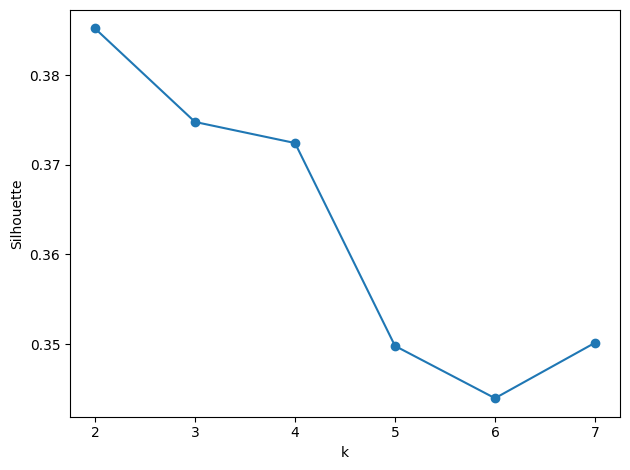

In [ ]:
from sklearn.metrics import silhouette_score, pairwise_distances

silhouette_vals = {k: silhouette_score(pca2, KMeans(k, n_init="auto", random_state=42).fit_predict(pca2)) for k in range(2,8)}
pd.Series(silhouette_vals).plot(marker='o');
plt.ylabel("Silhouette"); plt.xlabel("k"); plt.tight_layout(); plt.savefig(FIG/"silhouette.png", dpi=300)

I created and saved a box plot showing the distribution of mean temperature (°C) per cluster to help visualize the temperature differences between clusters, but kept it as a stand-in for interpretation and not used in the report.

In [ ]:
sns.boxplot(data=panel, x="cluster", y="t2m_C");
plt.savefig(FIG/"box_t_by_cluster.png"); plt.clf()

<Figure size 640x480 with 0 Axes>

Here is how I used 5-fold cross validation to estimate the mean ROC-AUC score for a logistic regression model predicting next-day fire risk based on temperature, wind, and humidity characteristics.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
X = panel[["t2m_C","wind_ms","rh_pct"]].fillna(method="ffill")
y = panel["target_next_day"]
print("LogReg 5-fold AUC:", cross_val_score(LogisticRegression(max_iter=200), X, y, cv=5, scoring="roc_auc").mean())

LogReg 5-fold AUC: 0.684908346414075


I created and saved a contour map showing the total number of hotspots per region (2014-24) and used quantile color classification to visualize regional ignition patterns.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 5.5 MB/s eta 0:00:00


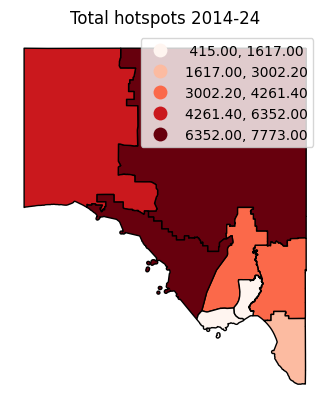

In [ ]:
!pip install mapclassify
import mapclassify as mc

region_sum = ignitions.groupby("nrm_id")["hotspot_cnt"].sum()
nrm_plot = nrm.merge(region_sum, on="nrm_id")
nrm_plot.plot(column="hotspot_cnt", scheme="quantiles", cmap="Reds", legend=True, edgecolor="k")

plt.axis("off"); plt.title("Total hotspots 2014-24");
plt.savefig(FIG/"choropleth_hotspots.png", dpi=300)

This works perfectly for a logistic regression model and prints the rounding coefficients for each feature and shows their impact on the prediction of next day ignition risk.

In [ ]:
coef = pd.Series(LogisticRegression(max_iter=200).fit(X, y).coef_[0], index=X.columns) ; print(coef.round(3))

t2m_C      0.131
wind_ms   -0.167
rh_pct     0.025
dtype: float64


Here, a logistic regression model is fitted to predict ignition risk, and a confusion matrix and classification report (precision, recall, F1, accuracy) are printed to evaluate model performance.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = LogisticRegression(max_iter=200).fit(X, y).predict(X)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, digits=3))


[[19182     0]
 [  334     0]]
              precision    recall  f1-score   support

         0.0      0.983     1.000     0.991     19182
         1.0      0.000     0.000     0.000       334

    accuracy                          0.983     19516
   macro avg      0.491     0.500     0.496     19516
weighted avg      0.966     0.983     0.974     19516



I fit a logistic regression using standardized features and then print the standardized coefficients and show the relative impact of each feature on the model's predictions.

In [ ]:
std_coef = pd.Series(
    LogisticRegression(max_iter=200).fit(
        (X - X.mean())/X.std(), y
    ).coef_[0], index=X.columns
).round(2)
print("Standardised β:", std_coef.to_dict())


Standardised β: {'t2m_C': 0.85, 'wind_ms': -0.29, 'rh_pct': 0.46}


Here I train a balanced logistic regression model to address the class imbalance problem, calculate its average ROC-AUC through 5-fold cross validation, and finally round the result to three decimal places for printing.

In [ ]:
log_bal = LogisticRegression(max_iter=200, class_weight="balanced")
auc_bal = cross_val_score(log_bal, X, y, cv=5, scoring="roc_auc").mean()
print("Balanced-logreg AUC:", round(auc_bal, 3))


Balanced-logreg AUC: 0.685


Here I apply t-SNE to reduce the weather features to two dimensions, add the results to the data, visualize the clusters using a scatter plot, and finally save a figure showing the daily pattern of the weather.

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# reuse the z-scored feature matrix `std`
tsne2 = TSNE(n_components=2, perplexity=50, random_state=42).fit_transform(std)
panel.loc[feats.index, "tsne_x"] = tsne2[:, 0]
panel.loc[feats.index, "tsne_y"] = tsne2[:, 1]

plt.figure(figsize=(6, 5))
sns.scatterplot(data=panel, x="tsne_x", y="tsne_y", hue="cluster",
                palette="tab10", s=5, linewidth=0)
plt.axis("off")
plt.title("t-SNE clusters of weather days")
plt.tight_layout()
plt.savefig(FIG / "tsne_clusters.png", dpi=300); plt.clf()


<Figure size 600x500 with 0 Axes>

Here a scatter plot of temperature versus number of hotspots with a transparent overlay is created, a smooth LOWESS regression line is added using a logarithmic y-axis, and then the layered visualization is saved.

In [ ]:
sns.scatterplot(data=panel, x="t2m_C", y="hotspot_cnt",
                alpha=0.3, s=10, edgecolor=None)

sns.regplot(data=panel, x="t2m_C", y="hotspot_cnt",
            scatter=False, lowess=True,
            line_kws={"linewidth": 2, "color": "black"})

plt.yscale("log")
plt.ylabel("Hotspot count (log)")
plt.xlabel("Mean air temperature (°C)")
plt.title("Layered scatter with LOWESS smooth")
plt.tight_layout()
plt.savefig(FIG / "scatter_layered.png", dpi=300); plt.clf()


<Figure size 640x480 with 0 Axes>

I saved a faceted scatter plot showing the relationship between temperature and hotspot count for each NRM region separately, with a logarithmic scaled y-axis for better visualization.

In [ ]:
g = sns.relplot(
        data=panel, x="t2m_C", y="hotspot_cnt",
        kind="scatter", col="nrm_id",
        col_wrap=3, height=3,
        facet_kws=dict(sharey=False),
        alpha=0.25, s=8
)
g.set(yscale="log")
g.set_axis_labels("T (°C)", "Hotspots (log)")
g.fig.suptitle("Temperature vs hotspot count by NRM region", y=1.02)
plt.tight_layout()
g.savefig(FIG / "facet_scatter_by_region.png", dpi=300); plt.clf()

<Figure size 900x900 with 0 Axes>

I saved an interactive Folium choropleth map showing the total number of hotspots per region (2014-24) with color shading and a legend, allowing spatial fire patterns to be explored in a web browser. This is, of course, for a possible later, legible presentation.

In [ ]:
import folium
from folium import Choropleth

# nrm_plot already has geometry +hotspot totals
nrm_plot = nrm_plot.to_crs(4326)
m = folium.Map([-30, 135], zoom_start=5, tiles="cartodbpositron")

Choropleth(
    geo_data=nrm_plot.__geo_interface__,
    data=nrm_plot,
    columns=["nrm_id", "hotspot_cnt"],
    key_on="feature.properties.nrm_id",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.4,
    legend_name="Total hotspots 2014-24"
).add_to(m)

m.save(str(FIG / "hotspots_map.html"))
print("Interactive map saved: ", FIG / "hotspots_map.html")


Interactive map saved → /content/drive/MyDrive/silo_agg/output/figures/hotspots_map.html


Finally I have listed the saved graphic files showing the four key images presented in the report and finally a table of style cluster profiles with color gradients for easier interpretation.


Saved figures:
 • hist_hotspots.png
 • corr_heatmap.png
 • scatter_t_hotspots.png
 • pca_clusters.png


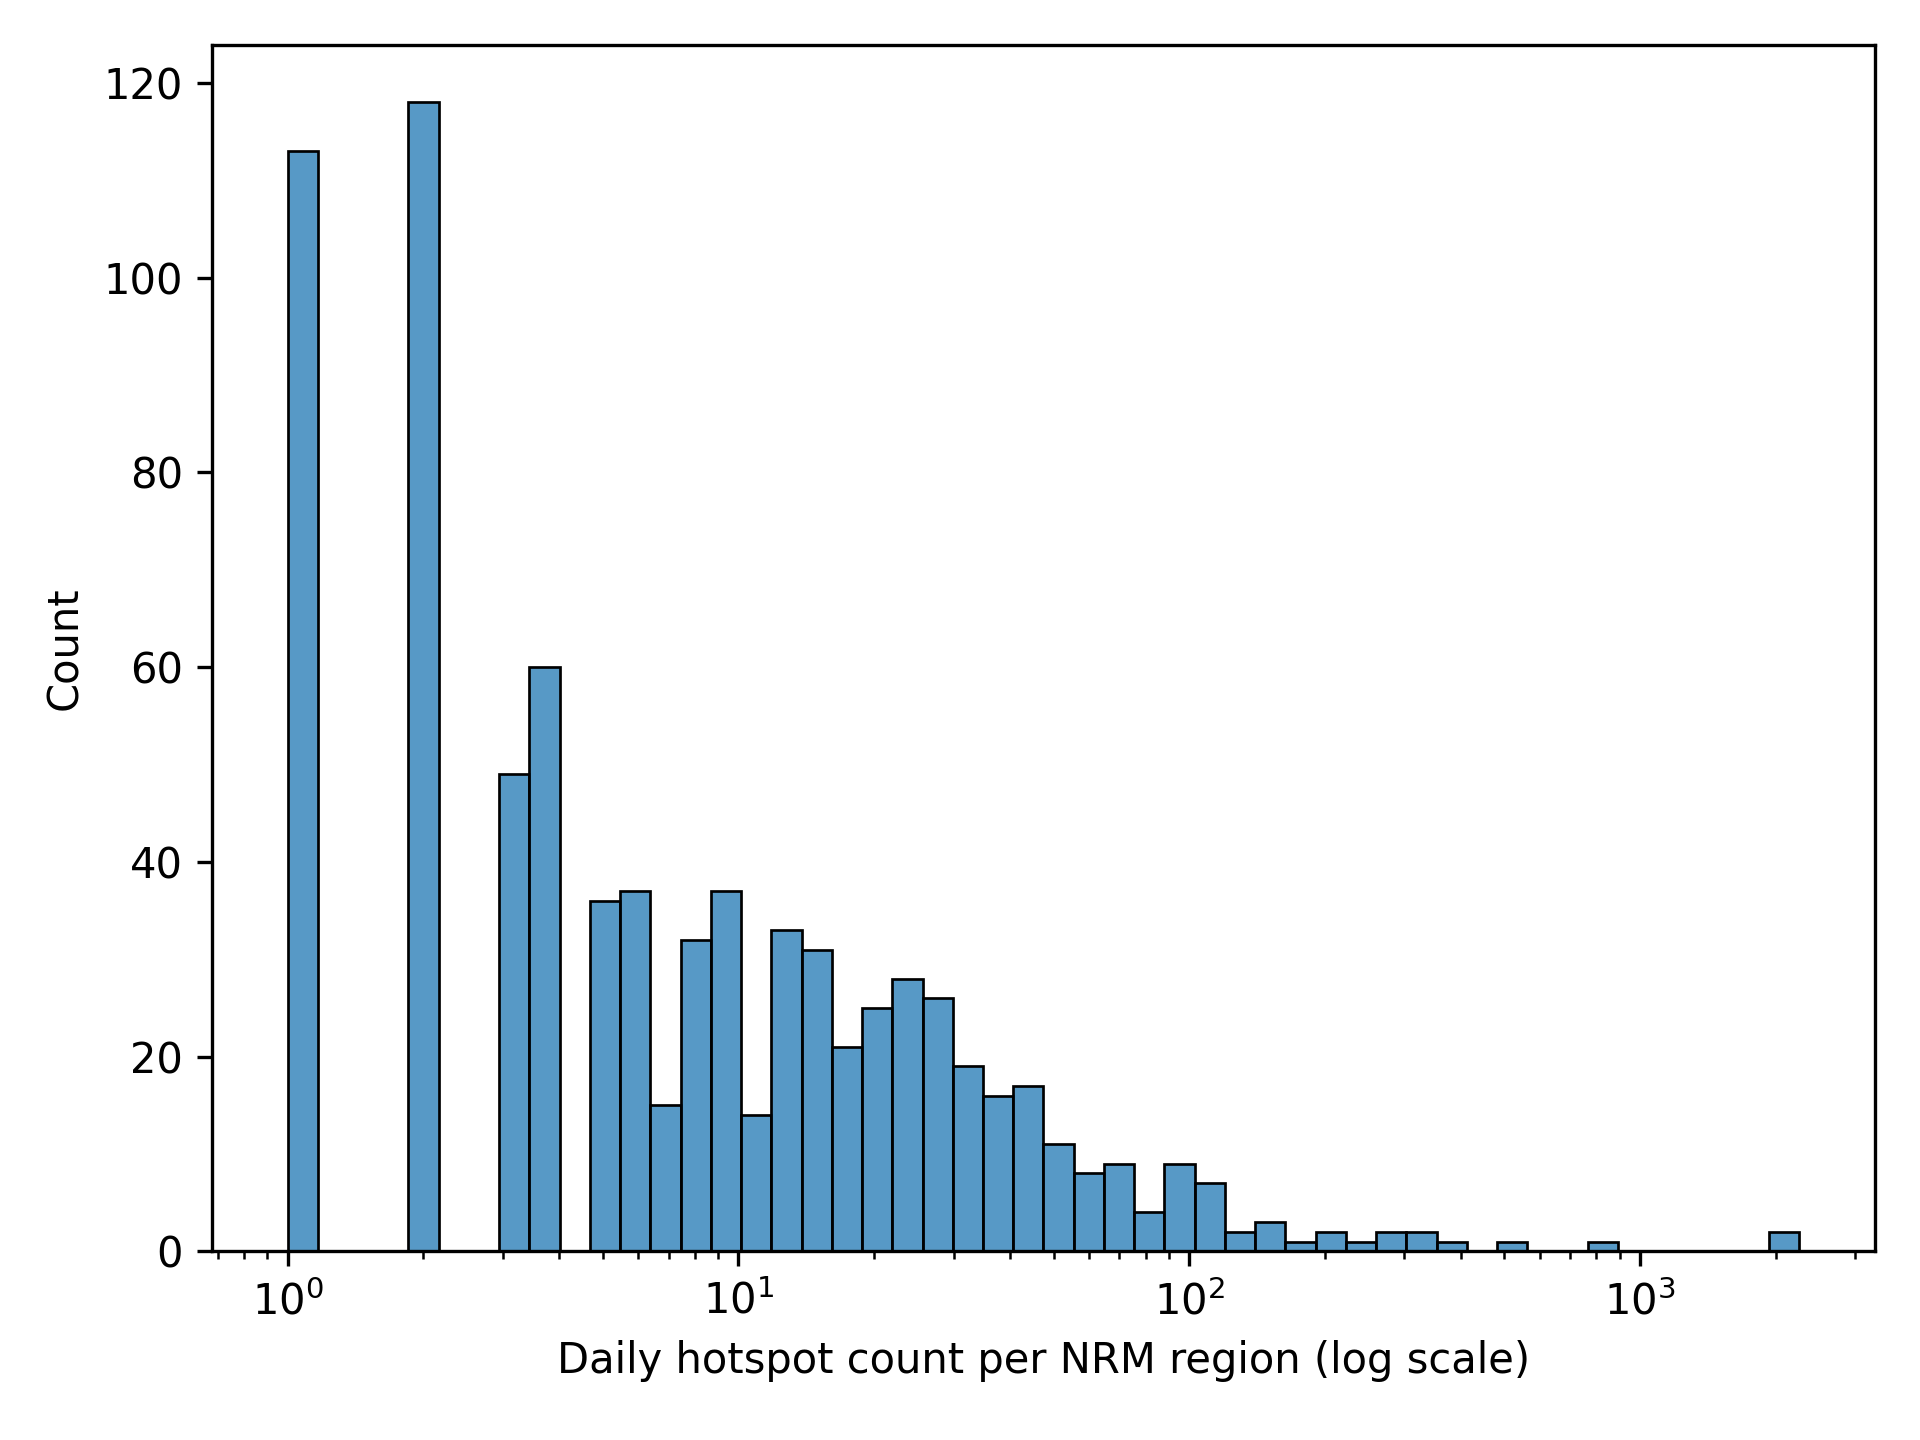

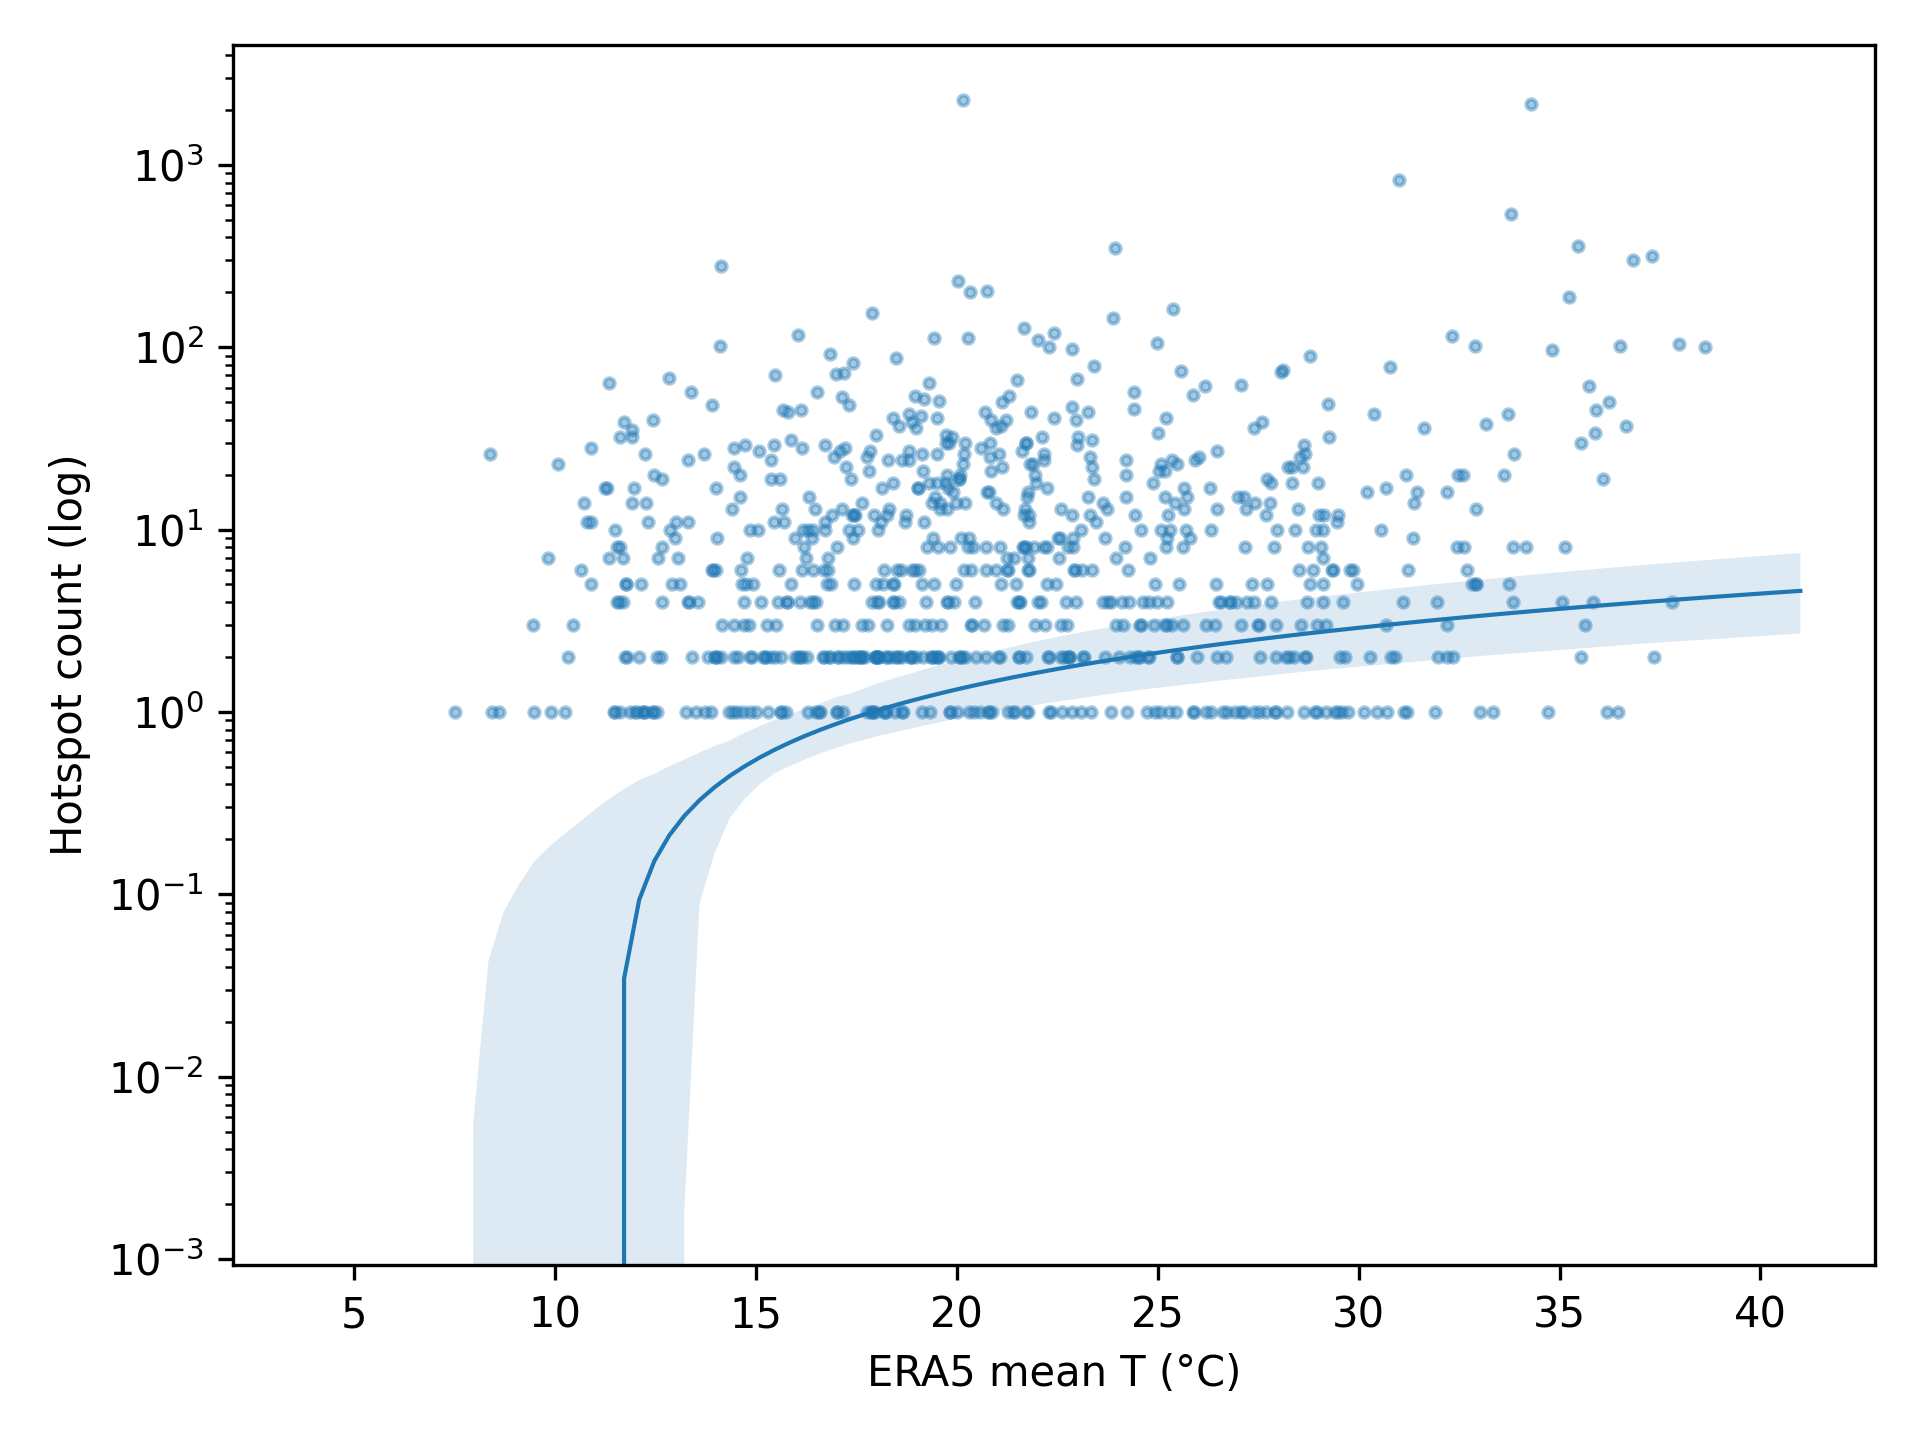

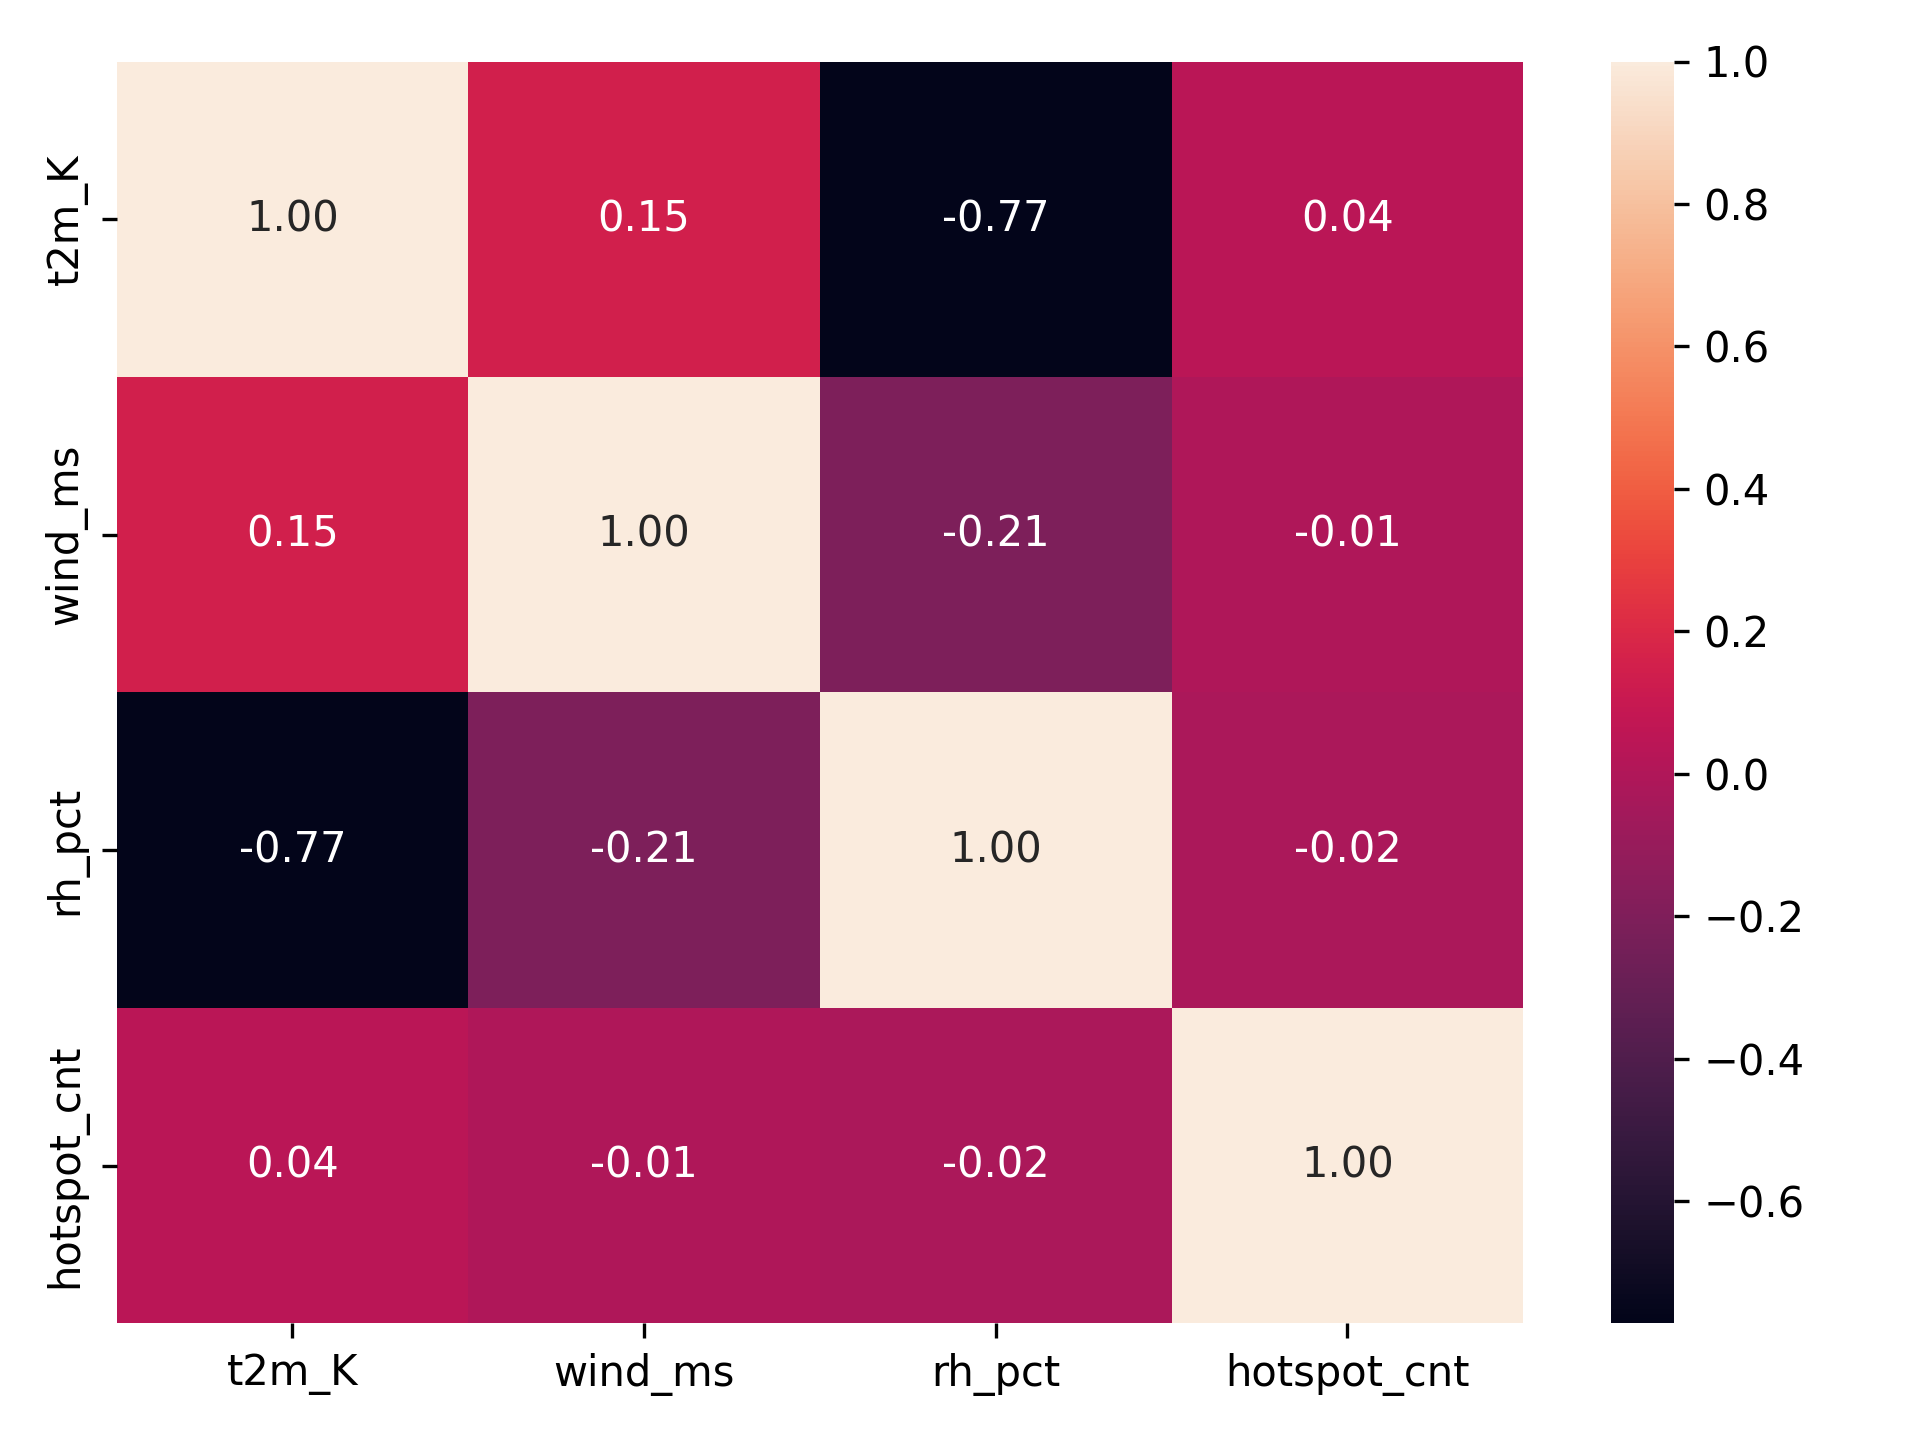

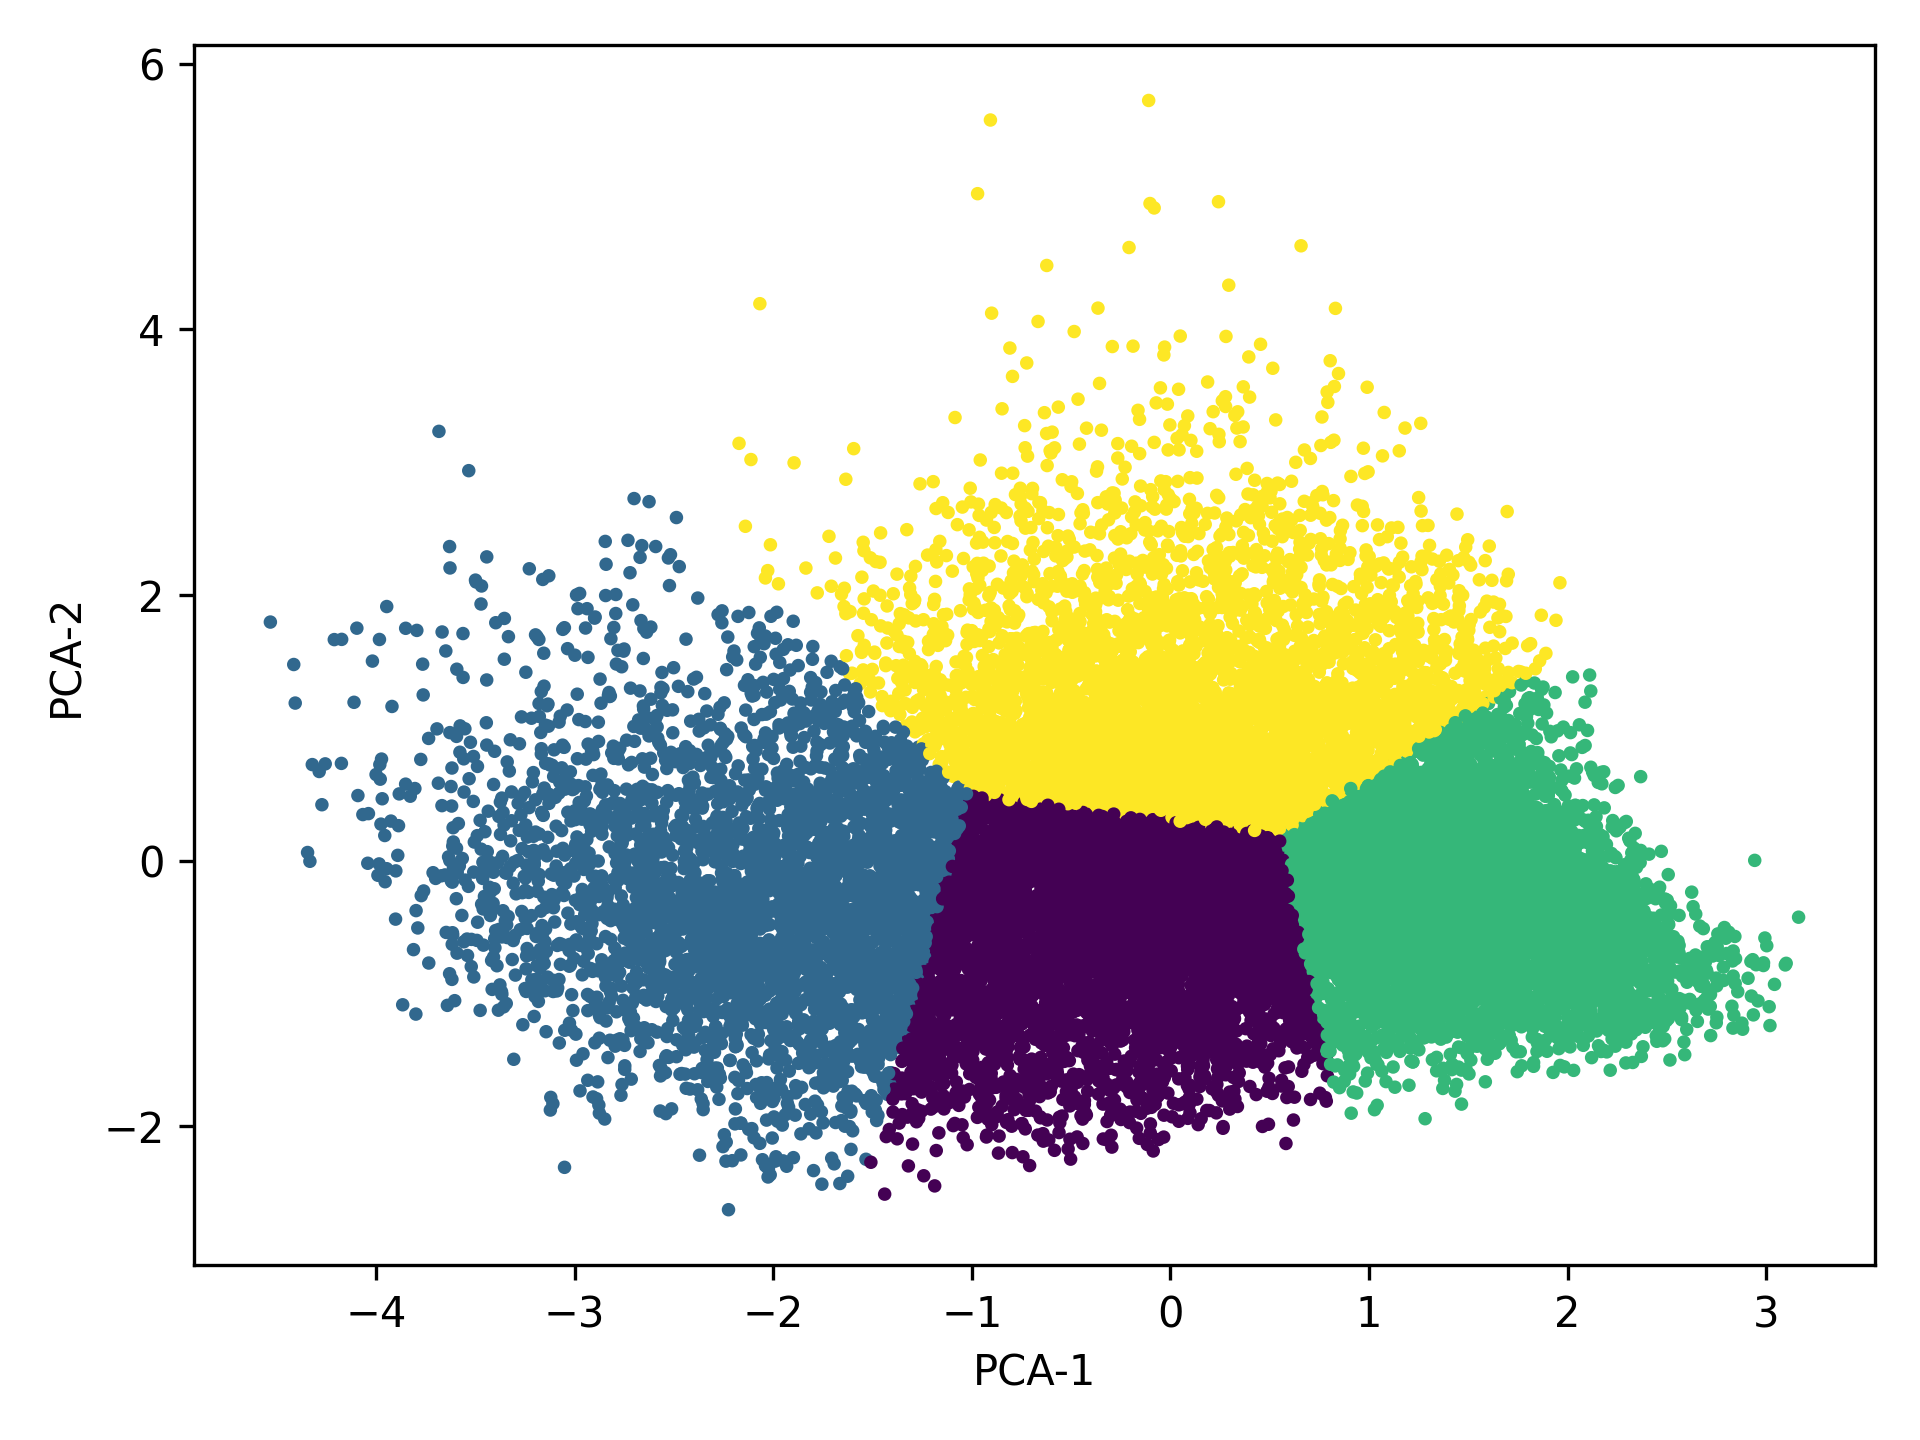

,cluster,mean_T_C,mean_w_ms,mean_rh,pct_high_risk
0,0.000000,19.780000,3.300000,50.200000,0.030000
1,1.000000,28.000000,4.770000,29.130000,0.020000
2,2.000000,11.780000,2.850000,74.150000,0.010000
3,3.000000,15.610000,6.070000,60.090000,0.010000


In [ ]:
from pathlib import Path
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd

FIG = Path("/content/drive/MyDrive/silo_agg/output/figures")

# 1. Verify the four PNGs really exist
print("\nSaved figures:")
for f in FIG.glob("*.png"):
    print(" •", f.name)

# 2. Inline preview
display(Image(filename=FIG/"hist_hotspots.png"))
display(Image(filename=FIG/"scatter_t_hotspots.png"))
display(Image(filename=FIG/"corr_heatmap.png"))
display(Image(filename=FIG/"pca_clusters.png"))

# 3. Pretty cluster-profile table
cluster_profile = pd.read_csv("/content/drive/MyDrive/silo_agg/output/cluster_profile.csv")
display(cluster_profile.style.background_gradient(cmap="YlOrBr", axis=0))
